## Langgraph를 활용한 Multi Agent 만들기 실습
#### 0. 사전 작업
- python 외부 library 설치 :

In [ ]:
!pip install -q python-dotenv langchain langsmith langgraph langchain-community langchain-core langchain-openai

- OpenAI Api Key 획득
- LangSmith 가입 (https://www.langchain.com/langsmith) 및 LANGCHAIN_API_KEY 생성

#### 1. 환경 변수 Load

In [2]:
# API Key를 환경변수로 관리하기 위한 설정 파일

from dotenv import load_dotenv

# API Key 정보로드
#   OPENAI_API_KEY = "" # OpenAI 구독 후 획득
#   LANGCHAIN_TRACING_V2 = "false"
#   LANGCHAIN_ENDPOINT = "https://api.smith.langchain.com"
#   LANGCHAIN_API_KEY = "" # LangSmith 가입 후 획득
load_dotenv(dotenv_path='./../.env')

# LangSmith에서 project 생성 후 사용.
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain_study" 

#### 2. State class 정의

In [3]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "The messages in the conversation"]
    next: Annotated[str, "The next agent to run"]
    topic: Annotated[str, "The topic of discussion"]

#### 3. llm 객체(ChatGPT) 생성

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    temperature=0.3,
    model="gpt-4o",
)

#### 4. Agent 들 정의
- 질문자, 답변자, 요약자 3개 Agent를 만든다.
- 질문자는 주어진 주제에 대한 질의를 한다.
- 답변자는 질문자의 질의에 대한 답변을 한다.
- 요약자는 질문자와 답변자간 대화량이 충분한지를 판단하고 충분하면 대화를 종료하고 대화 내용을 요약한다.(Supervisor)

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage
from langgraph.graph import END

##### 4-1. 질문자 Agent
- Prompt 정의

In [6]:
# 질문자 Agent
questioner_system_text = """
당신은 호기심 많은 질문자입니다.
주어진 주제에 대해 이미 한 질문을 제외하고 한가지 질문을 해주세요.
"""
questioner_prompt = ChatPromptTemplate.from_messages([
    ("system", questioner_system_text),
    ("human", "주제: {topic}\n\n이전 대화:\n{chat_history}\n\n다음 질문:"),
])

- Agent 함수 정의

In [7]:
def questioner(state: AgentState):
    messages = state['messages']
    topic = state['topic']
    chat_history = "\n".join([f"{m.name}: {m.content}" for m in messages])
    response = llm.invoke(questioner_prompt.format_messages(topic=topic, chat_history=chat_history))
    return {
        "messages": messages + [AIMessage(content=response.content, name="questioner")],
        "next": "answerer"
    }

##### 4-2. 답변자 Agent
- Prompt 정의

In [8]:
# 답변자 Agent
answerer_system_text = """
당신은 지식이 풍부한 답변자입니다. 
질문자의 질문에 대해 정보를 제공하고 대화를 이어나가는 답변을 해주세요. \
단, 답변은 100자 이내로 짧게 이전에 답하지 않은 한가지 내용만 답합니다.
"""
answerer_prompt = ChatPromptTemplate.from_messages([
    ("system", answerer_system_text),
    ("human", "주제: {topic}\n\n이전 대화:\n{chat_history}\n\n질문: {question}\n\n답변:"),
])

- Agent 함수 정의

In [9]:
def answerer(state: AgentState):
    messages = state['messages']
    topic = state['topic']
    chat_history = "\n".join([f"{m.name}: {m.content}" for m in messages[:-1]])
    question = messages[-1].content
    response = llm.invoke(answerer_prompt.format_messages(topic=topic, chat_history=chat_history, question=question))
    return {
        "messages": messages + [AIMessage(content=response.content, name="answerer")],
        "next": "summarizer"
    }

##### 4-3. 요약자 Agent (& Supervisor)
- Prompt 정의

In [10]:
# 요약자 Agent
summarizer_system_text = """
당신은 대화 요약자입니다. 
먼저 당신은 대화가 충분한지를 판단합니다.

충분한 대화란 다음을 만족해야 합니다.
 - questioner와 answerer간의 대화가 5회 이상 진행되어야 함

대화가 충분한 경우 대화를 분석하여 요약을 제공해주세요.
"""
summarizer_prompt = ChatPromptTemplate.from_messages([
    ("system", summarizer_system_text),
    ("human", "주제: {topic}\n\n대화:\n{chat_history}\n\n이 충분히 대화했나요? 그렇다면 '예'라고 답하고 대화를 요약해주세요. 그렇지 않다면 '아니오'라고만 답해주세요."),
])

- Agent 함수 정의

In [11]:
def summarizer(state: AgentState):
    messages = state['messages']
    topic = state['topic']
    chat_history = "\n".join([f"{m.name}: {m.content}" for m in messages])
    response = llm.invoke(summarizer_prompt.format_messages(topic=topic, chat_history=chat_history))
    
    return {
        "messages": messages + [AIMessage(content=response.content, name="summarizer")],
        "next": "route_summary"
    }

# 조건부 엣지 함수
def route_summary(state: AgentState):
    last_message = state["messages"][-1].content
    return "end" if last_message.lower().startswith("예") else "questioner"

#### 5. Graph 생성
- Graph 정의

In [12]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState)

- node 추가

In [13]:
workflow.add_node("questioner", questioner)
workflow.add_node("answerer", answerer)
workflow.add_node("summarizer", summarizer)

- edge 추가

In [14]:
workflow.add_edge("questioner", "answerer")
workflow.add_edge("answerer", "summarizer")

workflow.add_conditional_edges(
    "summarizer",
    route_summary,
    {
        "end": END,
        "questioner": "questioner"
    }
)

- 시작 node 설정

In [15]:
workflow.set_entry_point("questioner")

- Graph compile

In [16]:
app = workflow.compile()

- Graph 시작화

c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


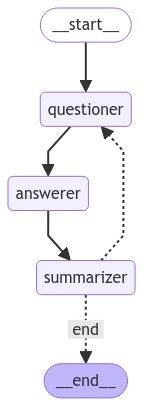

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### 6. Graph 실행

In [18]:
initial_state = {
    "messages": [],
    "next": "questioner",
    "topic": input() # 대화할 주제를 입력하세요.
}

for output in app.stream(initial_state):
    # 출력의 첫 번째 키를 가져옵니다
    agent = list(output.keys())[0]
    agent_output = output[agent]
    
    last_message = agent_output['messages'][-1]
    print(f"{last_message.name.capitalize()}: {last_message.content}")

    if agent == "summarizer":
        if last_message.content.lower().startswith("예"):
            print("충분한 정보가 수집되어 대화를 종료합니다.")
            print("최종 요약:", last_message.content)
            break
        else:
            print(f"Summarizer: 아직 충분한 정보가 수집되지 않았습니다. 대화를 계속합니다.")

c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Questioner: 일본의 전통 음식 중 하나인 스시의 기원은 무엇인가요?


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Answerer: 스시는 원래 생선을 보존하기 위해 쌀과 함께 발효시키는 방식에서 유래했습니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Summarizer: 아니오
Summarizer: 아직 충분한 정보가 수집되지 않았습니다. 대화를 계속합니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Questioner: 일본의 전통 의상인 기모노는 어떤 역사적 배경을 가지고 있나요?


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Answerer: 기모노는 헤이안 시대(794-1185)에 시작되어 에도 시대(1603-1868)에 현재의 형태로 발전했습니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Summarizer: 아니오
Summarizer: 아직 충분한 정보가 수집되지 않았습니다. 대화를 계속합니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Questioner: 일본의 전통 축제 중 하나인 마츠리는 어떤 의미와 역사를 가지고 있나요?


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Answerer: 마츠리는 일본의 전통 축제로, 신사에서 신을 기리기 위해 열리며, 지역마다 다양한 형태와 역사를 가지고 있습니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Summarizer: 아니오
Summarizer: 아직 충분한 정보가 수집되지 않았습니다. 대화를 계속합니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Questioner: 일본의 전통 예술 중 하나인 가부키는 어떤 특징과 역사를 가지고 있나요?


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Answerer: 가부키는 에도 시대에 시작된 전통 연극으로, 화려한 의상과 과장된 동작, 그리고 독특한 메이크업이 특징입니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Summarizer: 아니오
Summarizer: 아직 충분한 정보가 수집되지 않았습니다. 대화를 계속합니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Questioner: 일본의 전통 건축 양식 중 하나인 신사 건축은 어떤 특징과 역사를 가지고 있나요?


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Answerer: 신사 건축은 일본의 신토 신앙과 관련이 있으며, 간소한 목재 구조와 자연과의 조화를 중시하는 것이 특징입니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Summarizer: 예

요약: 이 대화에서는 일본의 다양한 전통 문화에 대해 논의했습니다. 스시의 기원은 생선을 보존하기 위해 쌀과 함께 발효시키는 방식에서 유래되었고, 기모노는 헤이안 시대에 시작되어 에도 시대에 현재의 형태로 발전했습니다. 마츠리는 신사를 중심으로 열리는 전통 축제로, 지역마다 다양한 형태와 역사를 가지고 있습니다. 가부키는 에도 시대에 시작된 전통 연극으로, 화려한 의상과 과장된 동작, 독특한 메이크업이 특징입니다. 마지막으로, 신사 건축은 일본의 신토 신앙과 관련이 있으며, 간소한 목재 구조와 자연과의 조화를 중시합니다.
충분한 정보가 수집되어 대화를 종료합니다.
최종 요약: 예

요약: 이 대화에서는 일본의 다양한 전통 문화에 대해 논의했습니다. 스시의 기원은 생선을 보존하기 위해 쌀과 함께 발효시키는 방식에서 유래되었고, 기모노는 헤이안 시대에 시작되어 에도 시대에 현재의 형태로 발전했습니다. 마츠리는 신사를 중심으로 열리는 전통 축제로, 지역마다 다양한 형태와 역사를 가지고 있습니다. 가부키는 에도 시대에 시작된 전통 연극으로, 화려한 의상과 과장된 동작, 독특한 메이크업이 특징입니다. 마지막으로, 신사 건축은 일본의 신토 신앙과 관련이 있으며, 간소한 목재 구조와 자연과의 조화를 중시합니다.


c:\Users\prof\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host '70.10.15.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
